In [1]:
import pandas as pd

# Load Dataset
df = pd.read_excel("/content/Online Retail.xlsx")

# Basic cleaning
df = df.dropna(subset=["CustomerID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# Covert date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

print("Rows:", len(df))
df.head()

Rows: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
import pandas as pd

# Copy dataframe
data = df.copy()

#Create Invoice Month
data["InvoiceMonth"] = data["InvoiceDate"].dt.to_period("M")

# Create Cohort Month
data["CohortMonth"] = data.groupby("CustomerID")["InvoiceMonth"].transform("min")

# Convert to timestamp for calculations
data["InvoiceMonth"] = data["InvoiceMonth"].dt.to_timestamp()
data["CohortMonth"] = data["CohortMonth"].dt.to_timestamp()

# Create Cohort Index (months since first purchase)
year_diff = data["InvoiceMonth"].dt.year - data["CohortMonth"].dt.year
month_diff = data["InvoiceMonth"].dt.month - data["CohortMonth"].dt.month

data["Cohort Index"] = year_diff * 12 + month_diff +1

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,InvoiceMonth,CohortMonth,Cohort Index
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1


In [6]:
import pandas as pd

# Customers per Cohort per Month
cohort_data = data.groupby(["CohortMonth", "Cohort Index"])["CustomerID"].nunique().reset_index()

# Pivot table (Retention matrix)
cohort_pivot = cohort_data.pivot(index="CohortMonth",
                                 columns="Cohort Index",
                                 values="CustomerID")


# Cohort size (month 1)
cohort_size = cohort_pivot.iloc[:, 0]

# Retention rate
retention = cohort_pivot.divide(cohort_size, axis=0)

retention.head()

Cohort Index,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02-01,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03-01,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04-01,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN


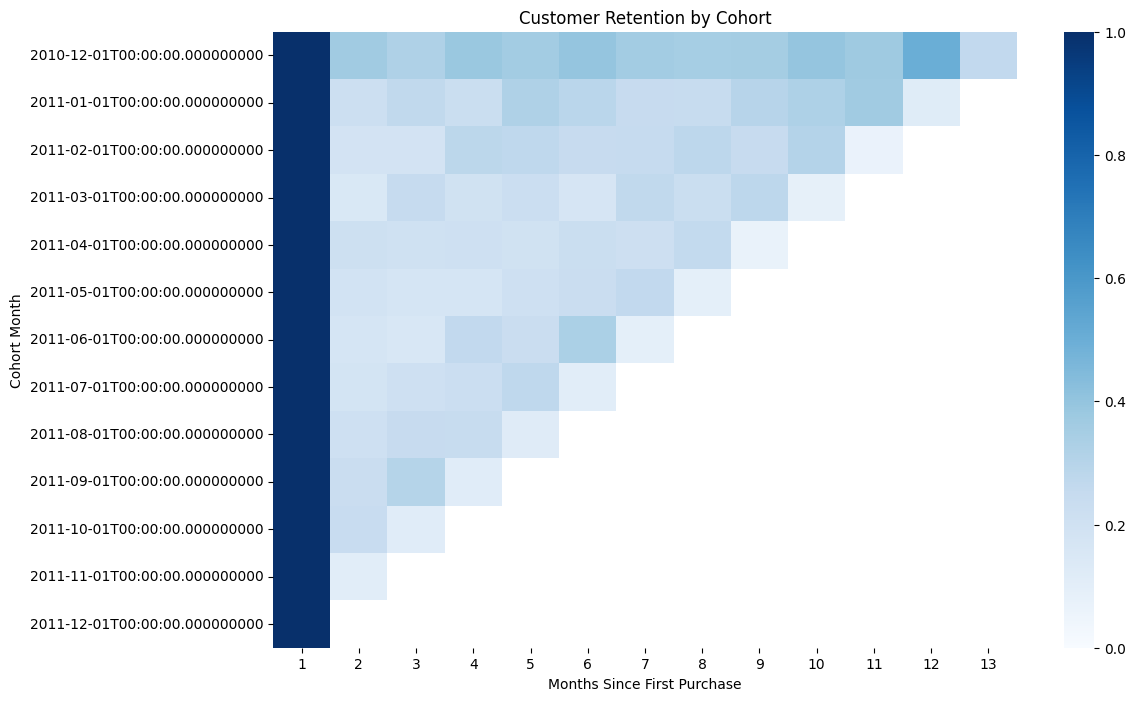

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(retention,
            annot=False,
            cmap="Blues",
            fmt=".0%",
            vmin=0,
            vmax=1)

plt.title("Customer Retention by Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

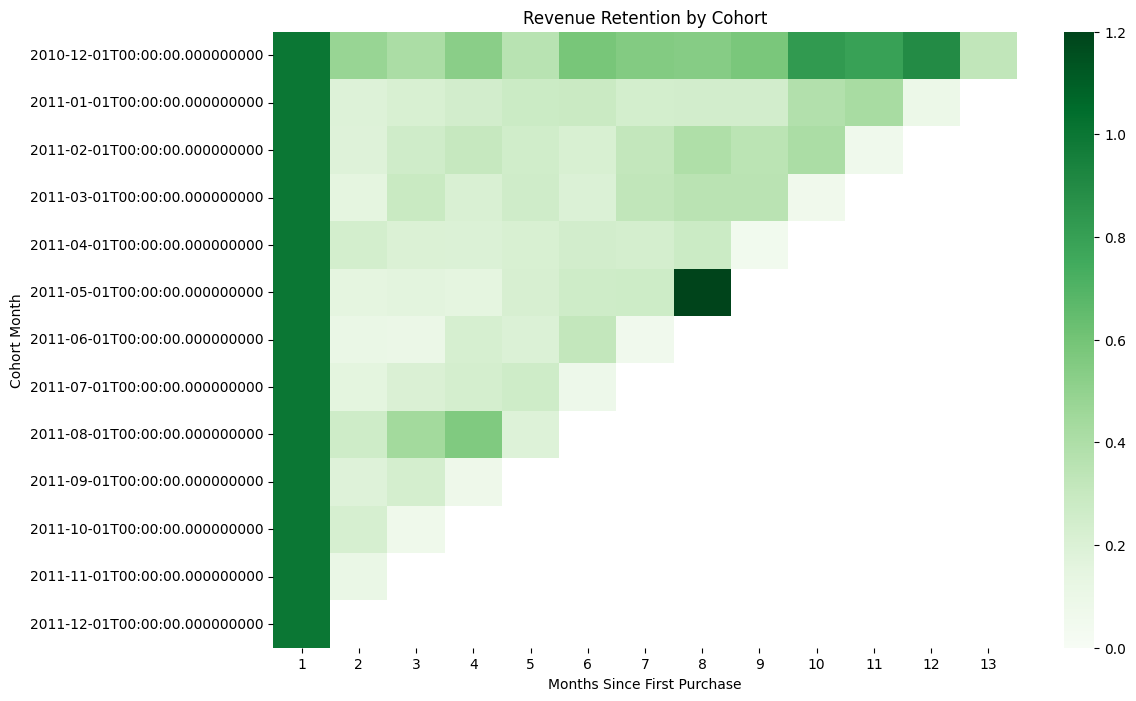

In [9]:
# Revenue per cohort per month
revenue_cohort = data.groupby(["CohortMonth", "Cohort Index"])["Revenue"].sum().reset_index()

revenue_pivot = revenue_cohort.pivot(index="CohortMonth",
                                     columns="Cohort Index",
                                     values="Revenue")


# Normalize by Month 1 revenue
revenue_base = revenue_pivot.iloc[:, 0]
revenue_retention = revenue_pivot.divide(revenue_base, axis=0)

revenue_retention.head()

plt.figure(figsize=(12,8))
sns.heatmap(revenue_retention,
            annot=False,
            cmap="Greens",
            vmin=0,
            vmax=1.2)

plt.title("Revenue Retention by Cohort")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.show()

Segment
Hibernating                1689
Loyal Customers            1038
Champions                   891
At Risk                     646
Return Recent Customers      74
Name: count, dtype: int64


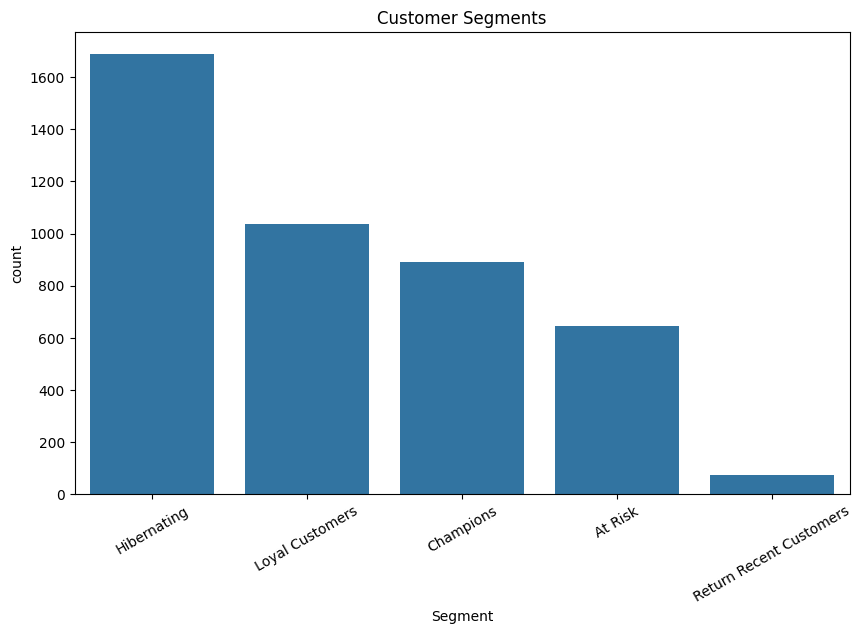

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reference date (last date in dataset)
snapshot_date = data["InvoiceDate"].max() + pd.Timedelta(days=1)

# RFM Table
rfm = data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "Revenue": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm.reset_index()

# Scoring
rfm["R_score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_score" ] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

# Calculate RFM group
rfm["RFM_Score"] = rfm[["R_score", "F_score", "M_score"]].astype(str).sum(axis=1)

def segment_customer(row):
    if row["R_score"] == 4 and row["F_score"] >= 3:
        return "Champions"
    elif row["R_score"] >= 3 and row["F_score"] >= 2:
        return "Loyal Customers"
    elif row["R_score"] == 4:
        return "Return Recent Customers"
    elif row["R_score"] <= 2 and row["F_score"] >= 3:
        return "At Risk"
    else:
        return "Hibernating"

# Apply segmentation
rfm["Segment"] = rfm.apply(segment_customer, axis=1)

print(rfm["Segment"].value_counts())

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=rfm, x="Segment", order=rfm["Segment"].value_counts().index)
plt.xticks(rotation=30)
plt.title("Customer Segments")
plt.show()

In [14]:
rfm.to_csv("rfm_segments.csv", index=False)